# Boletín 3: Árboles de Decisión

## Importamos las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Para evitar warnings en algunas gráficas
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})


## Definimos variables globales

In [3]:
# Establecemos esta semilla para eliminar aleatoriedad y obtener siempre los mismos resultados
SEED_VALUE = 1


## Ejercicio 1

En primer lugar, creamos el DataFrame con el conjunto de datos que aparece en el enunciado de este boletín:

In [4]:
df_ejercicio1 = [[4, 3, -1, 1],
                 [-3, -1, -1, 0],
                 [3, -2, 0, 0],
                 [1, 4, 0, 1],
                 [-2, 3, 1, 0],
                 [-3, 5, 5, 0]]
df_ejercicio1


[[4, 3, -1, 1],
 [-3, -1, -1, 0],
 [3, -2, 0, 0],
 [1, 4, 0, 1],
 [-2, 3, 1, 0],
 [-3, 5, 5, 0]]

**Construye el árbol de clasificación (sin podar) mediante CART y utilizando como criterio la entropía. La condición de parada debe ser que los nodos hoja sean puros (todos los ejemplos son de la misma clase). En cada nodo del árbol se debe indicar:**

- **La variable y su valor umbral.**
- **La entropía correspondiente.**
- **En los nodos hoja, la clase del nodo y los ejemplos que pertenecen al mismo.**

Definimos el código que usaremos para construir el árbol de clasificación sin podar mediante CART y utilizando como criterio la entropía:

In [5]:
# Calculate the Entropy for a split dataset
def get_cross_entropy(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))

	# sum weighted Entropy for each group
	cross_entropy = 0.0

	for group in groups:
		size = float(len(group))

		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0

		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			if(p != 0):
				score = score + (-p * np.log(p))

		# weight the group score by its relative size
		cross_entropy += score * (size / n_instances)
	return cross_entropy


# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = np.Inf, np.Inf, np.Inf, None

	for index in range(len(dataset[0]) - 1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			cross_entropy = get_cross_entropy(groups, class_values)
			if cross_entropy < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], cross_entropy, groups

	# Ordenamos en función del índice escogido para obtener el umbral
	dataset = np.array(dataset)
	sorted_dataset = dataset[np.argsort(dataset[:, b_index])]

	# Obtenemos el índice del valor escogido en el dataset ordenado
	index = list(sorted_dataset[:, b_index]).index(b_value)

	# Obtenemos el umbral
	b_value = (sorted_dataset[index - 1, b_index] +
	           sorted_dataset[index, b_index]) / 2.0

	return {'index': b_index, 'value': b_value, 'entropy': b_score, 'groups': b_groups, 'terminal': False}


def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return {'class': max(set(outcomes), key=outcomes.count), 'members': group, 'terminal': True}

# Create child splits for a node or make terminal
def split(node, min_size, depth):
	left, right = node['groups']
	del(node['groups'])

	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	elif get_cross_entropy([left], list(set(row[-1] for row in left))) == 0.0:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], min_size, depth+1)

	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	elif get_cross_entropy([right], list(set(row[-1] for row in right))) == 0.0:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], min_size, depth+1)


# Build a decision tree
def build_tree(train, min_size=1):
	root = get_split(train)
	split(root, min_size, 1)
	return root

# Print a decision tree
def print_tree(node, depth=0):
	if not node['terminal']:
		# Nodo normal
		print(
			f"{' ' * depth}[X{node['index'] + 1} < {node['value']}] -> Entropía {node['entropy']}")
		print_tree(node['left'], depth + 1)
		print_tree(node['right'], depth + 1)
	else:
		# Nodo hoja
		print(f"{' ' * depth}[{node['class']}] -> Miembros: {node['members']}")


Ahora construimos el árbol de decisión resultante y lo mostramos por pantalla:

In [6]:
tree = build_tree(df_ejercicio1)
print_tree(tree)


[X1 < -0.5] -> Entropía 0.3182570841474064
 [0] -> Miembros: [[-3, -1, -1, 0], [-2, 3, 1, 0], [-3, 5, 5, 0]]
 [X2 < 0.5] -> Entropía 0.0
  [0] -> Miembros: [[3, -2, 0, 0]]
  [1] -> Miembros: [[4, 3, -1, 1], [1, 4, 0, 1]]


## Ejercicio 2

Ahora trabajaremos con el conjunto de datos [Blood Transfusion Service Center](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center).

### Apartado 0

**Analiza las características del conjunto de datos: número y tipo de variables de entrada y salida, número de instancias, número de clases y distribución de las mismas, correlación entre las variables, valores perdidos, etc.**

Ahora empezamos con el análisis de las características del conjunto de datos. En primer lugar, leemos los datos del fichero de entrada:

In [7]:
df_blood_transfusion = pd.read_csv('data/bloodTransfusion.data', 
                      delimiter=',',
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "IsMarchDonor"])


Ahora visualizamos las primeras filas para ver el número y tipo de las variables de entrada y salida:

In [8]:
df_blood_transfusion


,Recency,Frequency,Monetary,Time,IsMarchDonor
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


Cada columna de este DataFrame representa la siguiente información:
- **Recency**: el número de meses que han pasado desde la última donación.
- **Frequency**: el número total de donaciones de esta persona.
- **Monetary**: cantidad total de sangre donada en centímetros cúbicos (c.c.).
- **Time**: el número de meses desde la primera donación de esta persona.
- **IsMarchDonor**: la variable a predecir, que nos indica si esta persona donó o no en Marzo de 2007 (1 significa que donó mientras que 0 indica que no donó).


El número de instancias presentes en el DataFrame es el siguiente:

In [9]:
df_blood_transfusion.shape[0]


748

Comprobamos el tipo de dato de cada una de las columnas presentes en el DataFrame:

In [10]:
print('Tipo de dato de cada columna del Dataframe :')
print(df_blood_transfusion.dtypes)


Tipo de dato de cada columna del Dataframe :
Recency         int64
Frequency       int64
Monetary        int64
Time            int64
IsMarchDonor    int64
dtype: object


Como se puede ver, todas las columnas contienen valores enteros. Ahora continuaremos con las gestión de los valores perdidos. En primer lugar comprobaremos si hay alguno en el DataFrame:

In [11]:
print("Número de valores NaN en cada columna:")
df_blood_transfusion.isna().sum()


Número de valores NaN en cada columna:


Recency         0
Frequency       0
Monetary        0
Time            0
IsMarchDonor    0
dtype: int64

Como se puede ver **no** hay valores perdidos en nuestro DataFrame, sin embargo, en caso de que los hubiese se podría solucionar este problema con el siguiente código, aunque debería ejecutarse después de haber dividido los datos en los conjuntos de entrenamiento y de test:

In [12]:
# # Rellenamos los valores faltantes con la media de la columna
# imp = SimpleImputer(missing_values=np.nan, fill_value='mean')
# imp = imp.fit(df_blood_transfusion)
# df_blood_transfusion_prep = imp.transform(df_blood_transfusion)

# # Convertimos de nuevo en DataFrame el array de numpy devuelto
# df_blood_transfusion = pd.DataFrame(df_blood_transfusion_prep,
#                        columns=df_blood_transfusion.columns,
#                        index=df_blood_transfusion.index)

# df_blood_transfusion


Ahora estudiaremos el número de clases y la distribución de las mismas:

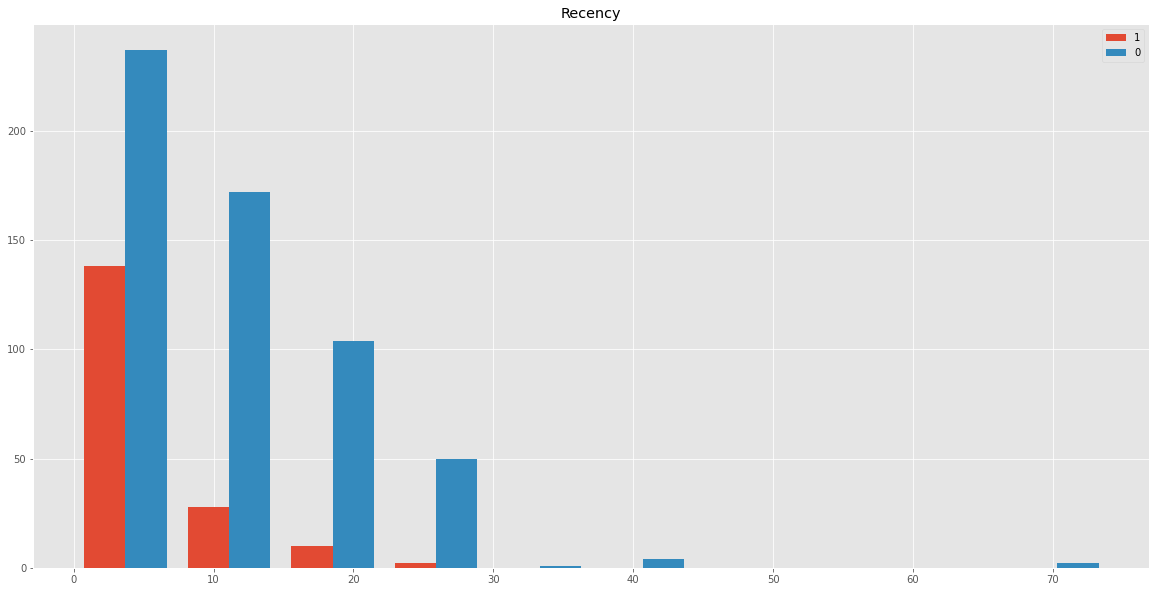

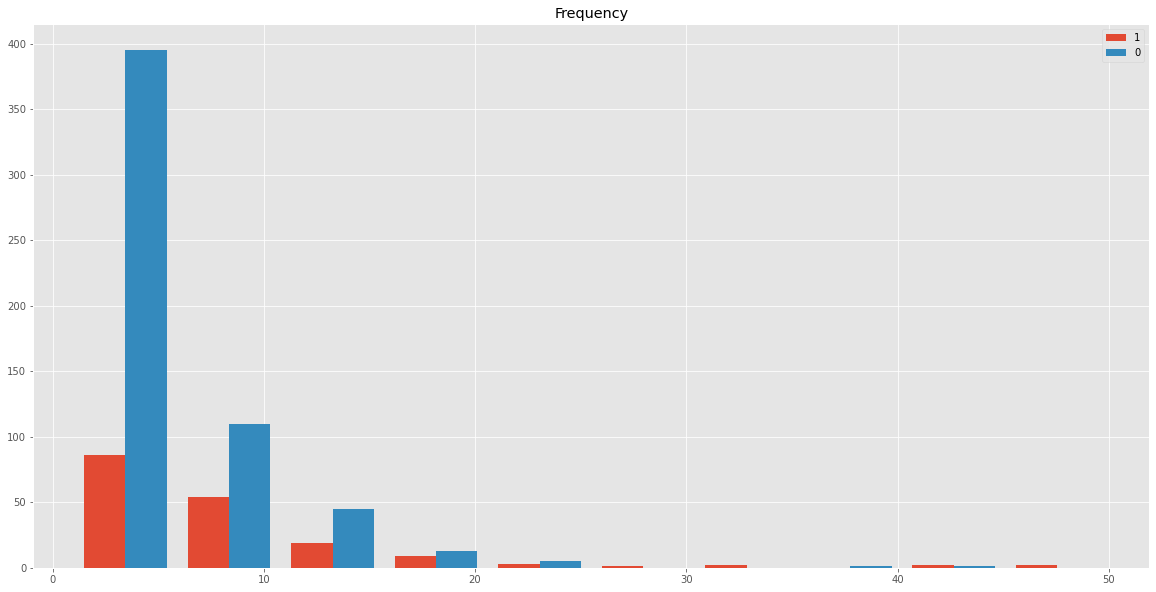

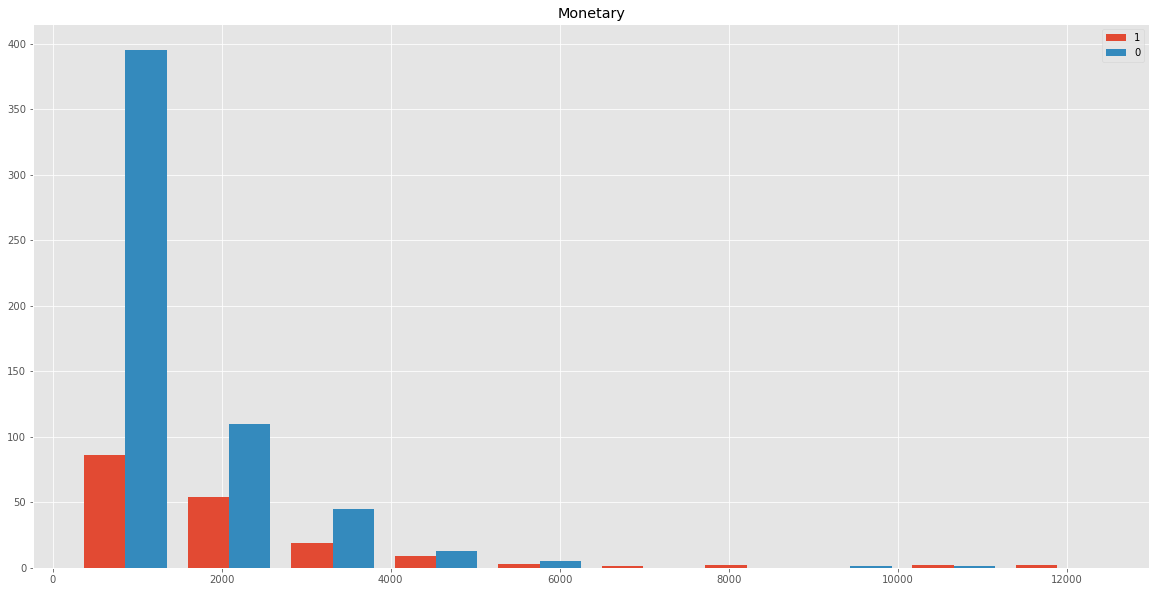

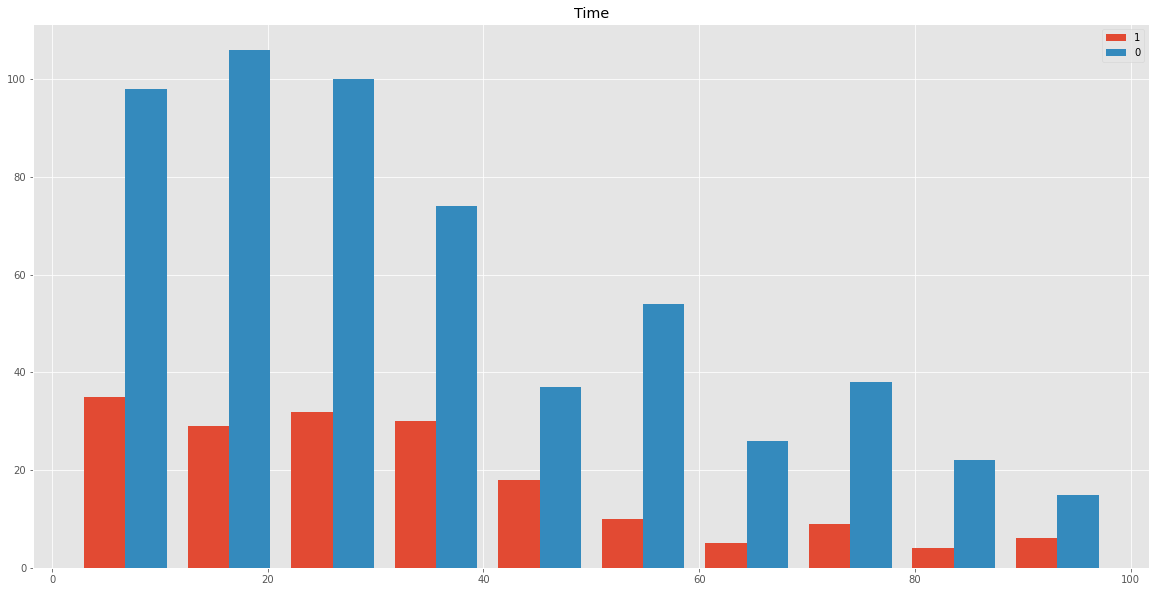

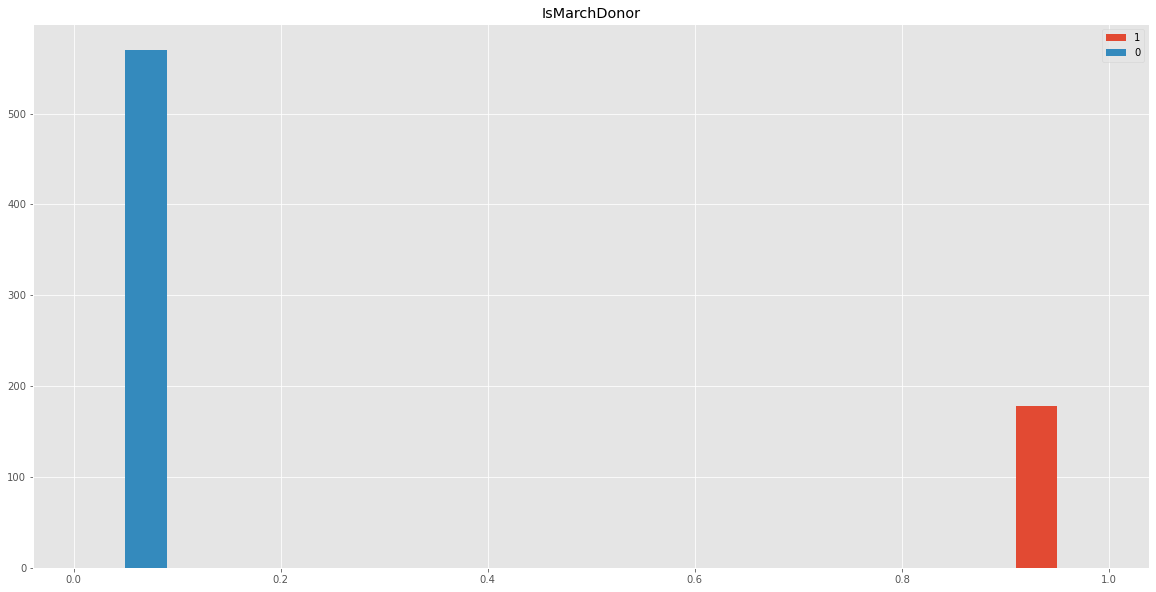

In [13]:
# Visualizamos la distribución de variables por clases
for column in df_blood_transfusion:
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(column)
    ax.hist([df_blood_transfusion[df_blood_transfusion['IsMarchDonor'] == 1][column], df_blood_transfusion[df_blood_transfusion['IsMarchDonor'] == 0][column]], label=['1', '0'])
    ax.legend(loc='upper right')


Como se puede ver, es posible que tengamos un problema en la recolección de los datos ya que hay un número mucho mayor de muestras para la categoría 0 (no donó en Marzo de 2007) que de la categoría 1.

Ahora, para terminar este apartado, comprobaremos la correlación entre las variables:

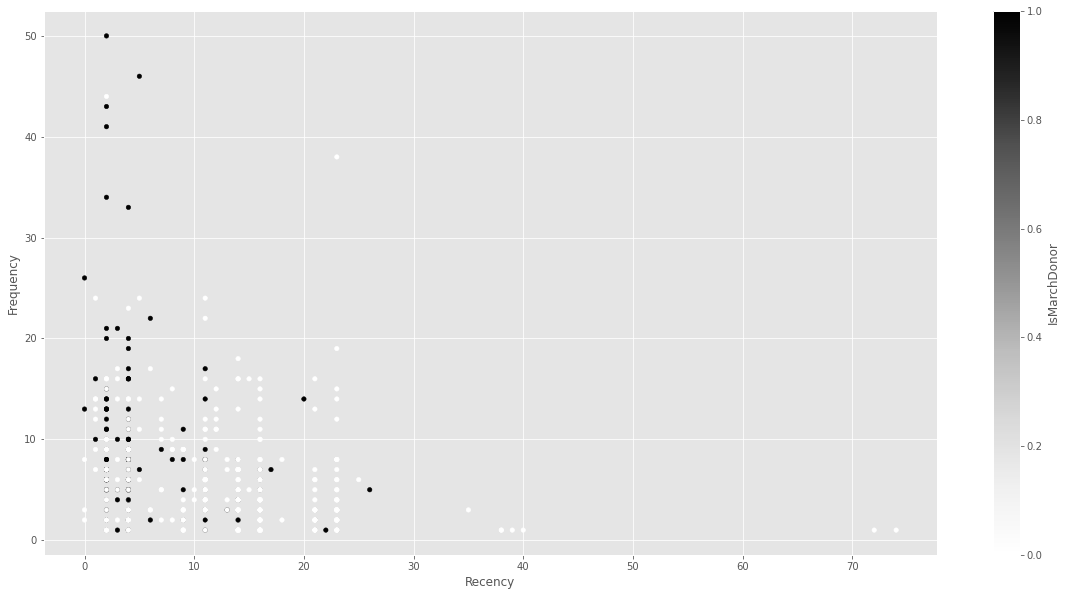

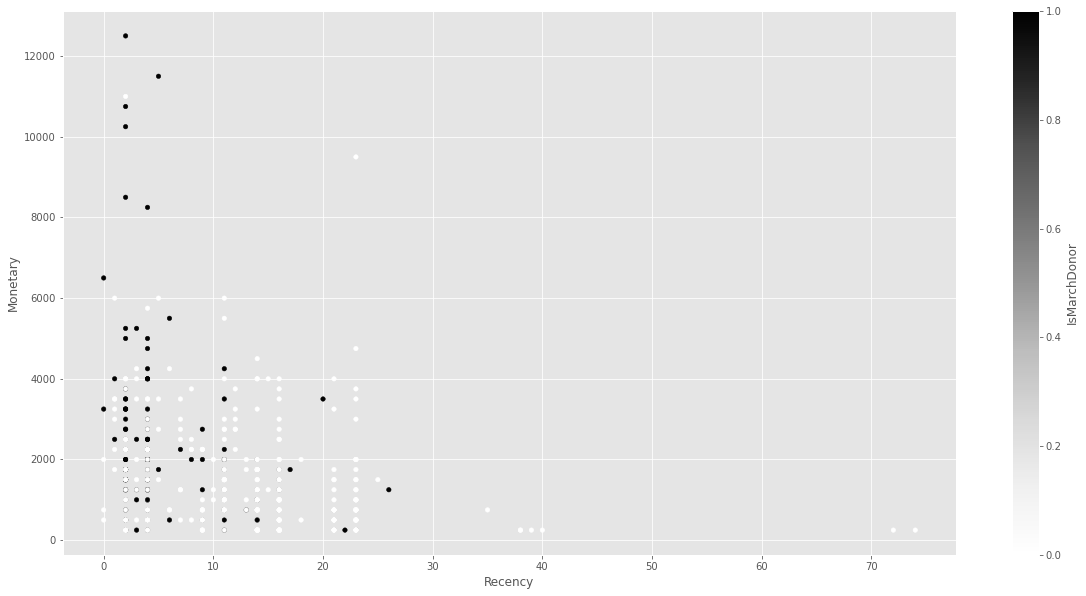

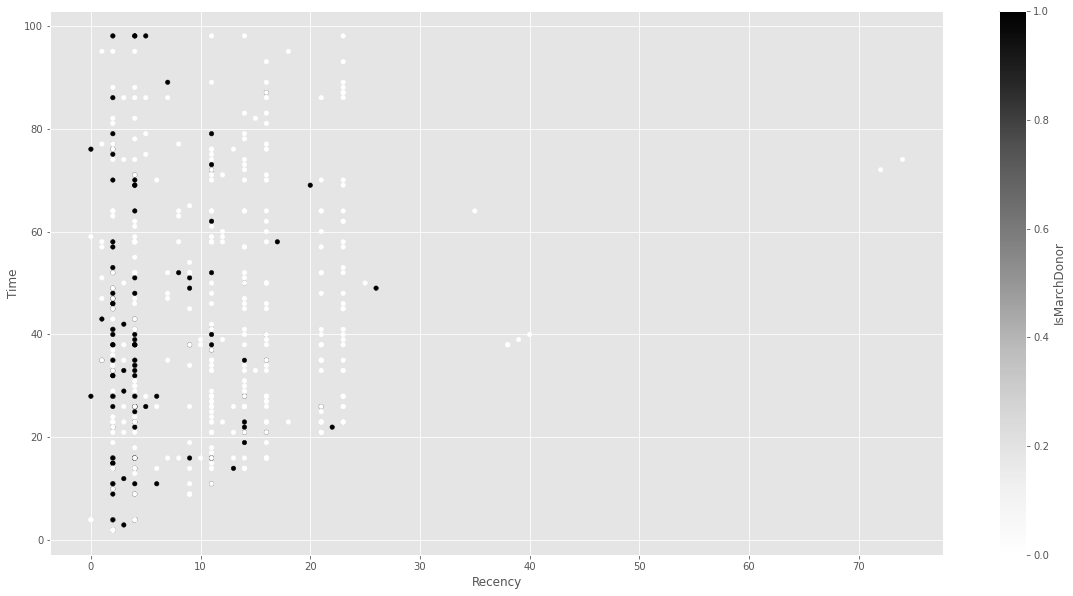

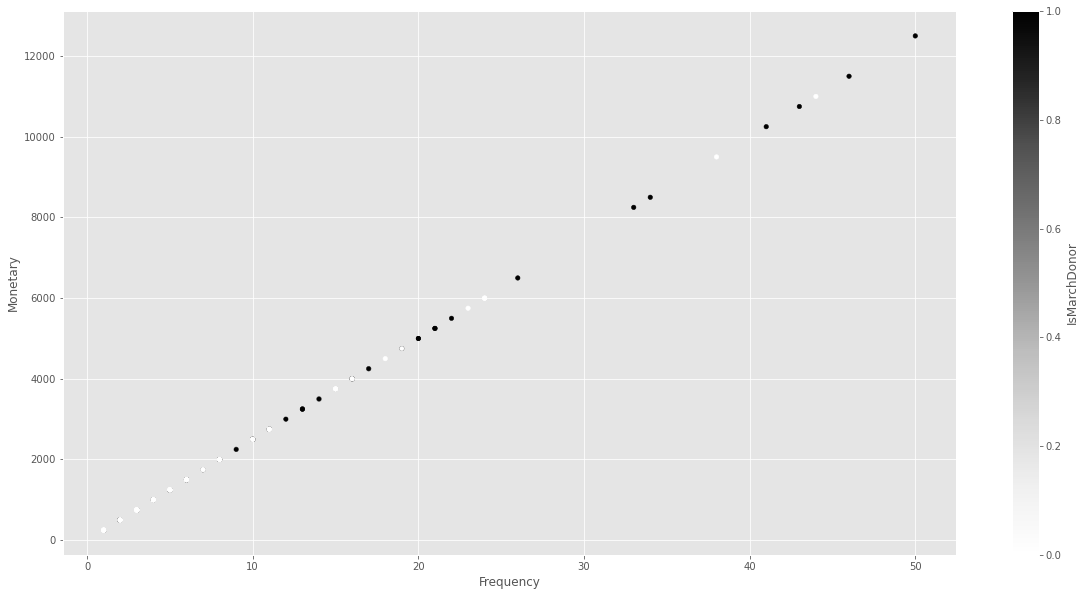

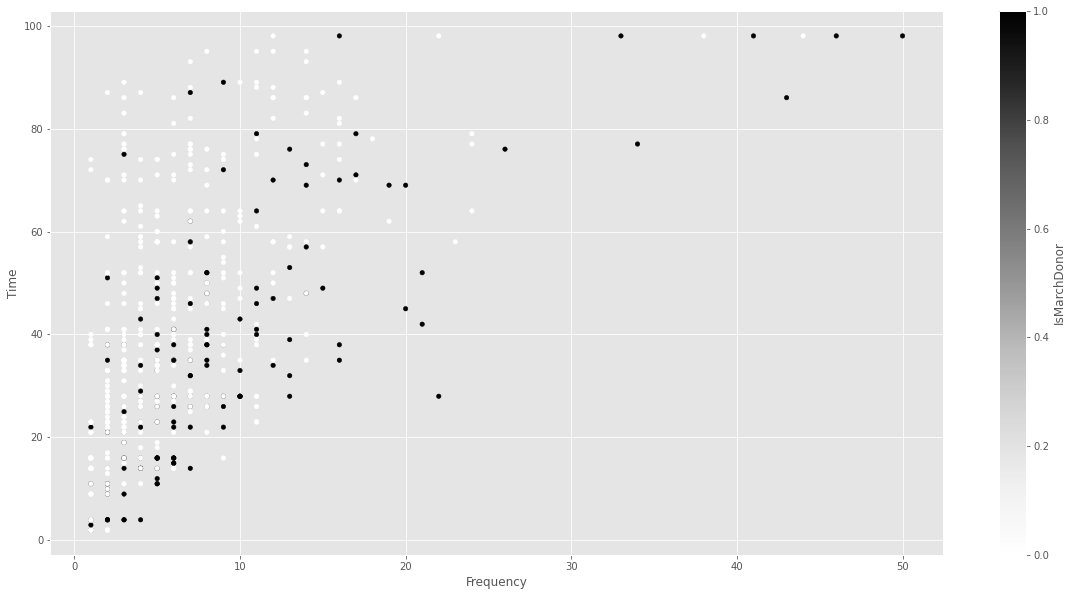

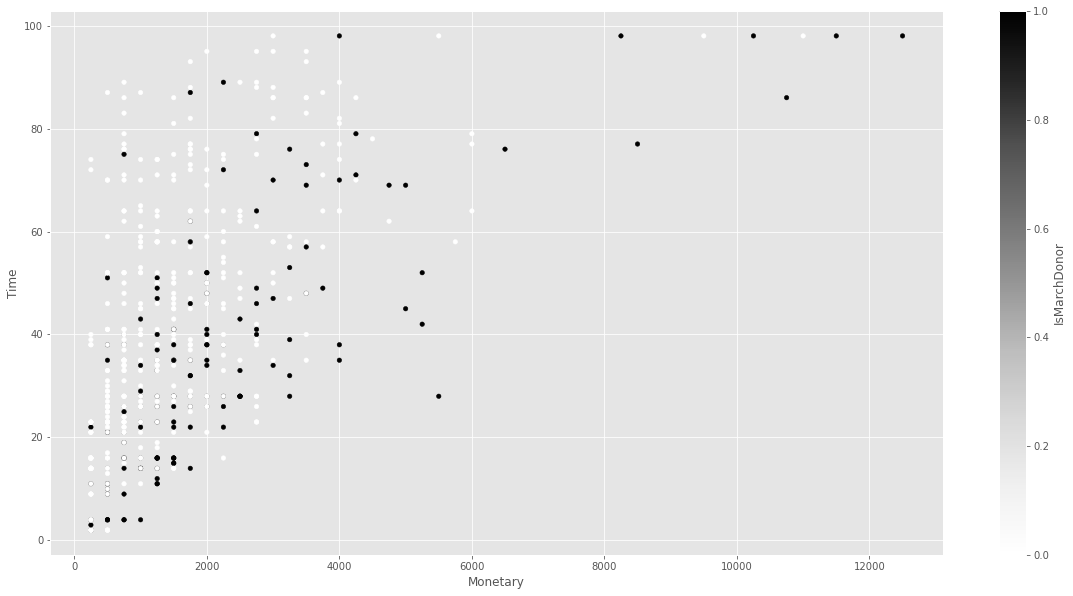

In [14]:
# Omitimos la variable dependiente
column_names = df_blood_transfusion.columns[:-1]

# Ahora representamos atributos por pares (mostrando también la clase)
for i, columna_i in enumerate(column_names):
    for j, columna_j in enumerate(column_names):
        if i < j:
            fig, ax = plt.subplots(figsize=(20,10))
            df_blood_transfusion.plot.scatter(columna_i, columna_j, c='IsMarchDonor', ax=ax)

Como se puede ver, las variables *Frequency* y *Monetary* están directamente relacionadas. Esto tiene sentido ya que si cada vez que se dona se dona la misma cantidad de sangre (en c.c.), el número de veces que se ha donado (*Frequency*) nos dará la información necesaria para saber la cantidad de sangre donada en c.c. (*Monetary*).

Podríamos eliminar alguna de estas dos variables y no debería tener efecto en nuestro modelo, ya que nos indican la misma información.

Por otra parte, también parece haber algún tipo de correlación entre *Time* y *Monetary*, y entre *Time* y *Frequency*.

### Apartado a

**Una de las clases que implementa el algoritmo CART en `scikit‐learn` es `sklearn.tree.DecisionTreeClassifier`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.tree.DecisionTreeClassifier` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado b

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [15]:
df_blood_transfusion_train, df_blood_transfusion_test = train_test_split(
    df_blood_transfusion,
    test_size=0.2,
    random_state=SEED_VALUE
)


Comprobamos el tamaño del conjunto de entrenamiento:

In [16]:
df_blood_transfusion_train.shape


(598, 5)

Y el tamaño del conjunto de test:

In [17]:
df_blood_transfusion_test.shape


(150, 5)

### Apartado c

**Realiza la experimentación con *DecisionTreeClassifier* usando los valores por defecto de los parámetros, excepto para criterion que debe tomar el valor ’entropy’. Además, utiliza como hiper-parámetro la variable min_samples_split (permitirá modificar el tamaño del árbol).**

En primer lugar, para llevar a cabo la experimentación con *DecissionTreeClassifier* es necesario que separemos las variables predictoras y dependientes:

In [18]:
df_blood_transfusion_train_X = df_blood_transfusion_train.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_train_Y = df_blood_transfusion_train.loc[:, 'IsMarchDonor']

df_blood_transfusion_test_X = df_blood_transfusion_test.loc[:, [
    'Recency', 'Frequency', 'Monetary', 'Time']].astype(float)
df_blood_transfusion_test_Y = df_blood_transfusion_test.loc[:, 'IsMarchDonor']


Ahora que ya hemos acabado con la visualización y el pre-procesado de los datos, podemos empezar con la experimentación. En primer lugar definimos los hiperparámetros con los que trabajaremos:

In [19]:
hyperparameters = {'min_samples_split': range(2, 201, 1)}


Ahora ejecutamos el entrenamiento:

In [20]:
decission_tree = DecisionTreeClassifier(criterion='entropy', random_state=SEED_VALUE)
modelCV = GridSearchCV(decission_tree,
                       hyperparameters,
                       cv=5,
                       return_train_score=True,
                       n_jobs=-1)

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV.fit(df_blood_transfusion_train_X, df_blood_transfusion_train_Y)


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=1),
             n_jobs=-1, param_grid={'min_samples_split': range(2, 201)},
             return_train_score=True)

Ahora podemos consultar los resultados obtenidos, mostrando un ranking con los mejores resultados ordenados de mejor a peor:

In [21]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results['mean_test_score'] = 1 - cv_results['mean_test_score']

cv_results.loc[:, [
    'param_min_samples_split', 
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
108,110,0.202409,0.017044,1
107,109,0.202409,0.017044,1
106,108,0.202409,0.017044,1
105,107,0.202409,0.017044,1
104,106,0.202409,0.017044,1
...,...,...,...,...
160,162,0.252619,0.046082,134
161,163,0.252619,0.046082,134
162,164,0.252619,0.046082,134
148,150,0.252619,0.046082,134


**Muestra la gráfica del error de entrenamiento con validación cruzada (5‐CV) frente al valor del hiper‐parámetro. ¿Cuál es el menor error de validación cruzada, su desviación estándar y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar?**

Mostramos la gráfica con los resultados del entrenamiento:

<ErrorbarContainer object of 3 artists>

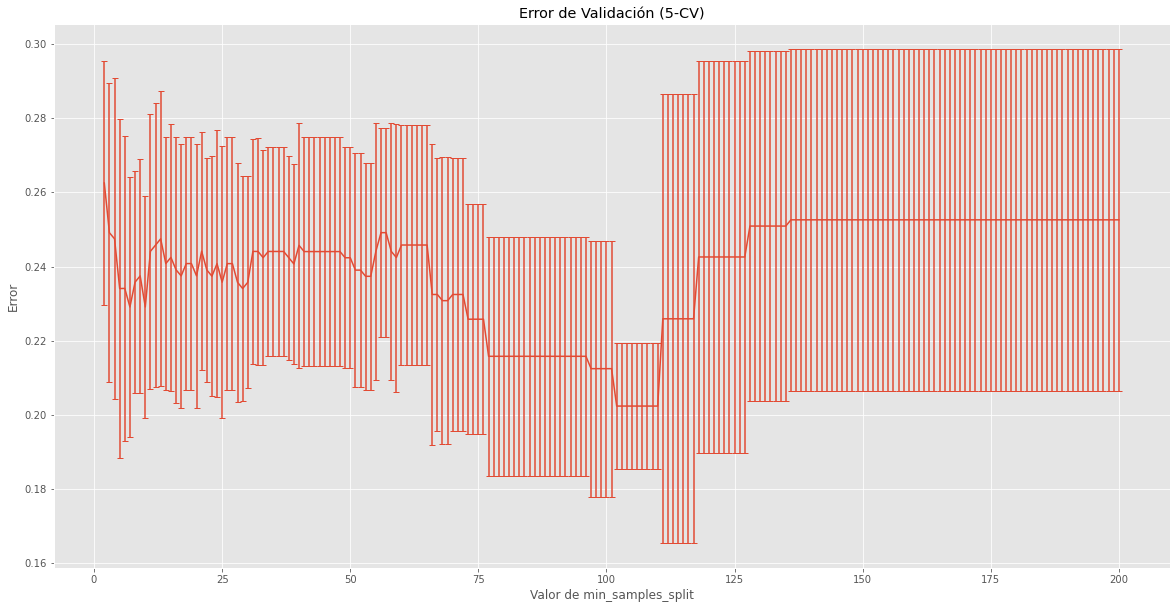

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de min_samples_split")
ax.set_ylabel("Error")
ax.errorbar(
    cv_results['param_min_samples_split'], 
    cv_results['mean_test_score'], 
    cv_results['std_test_score'], 
    capsize=3)


El menor error de validación cruzada, su desviación estándar y el hiper-parámetro para el que se consigue es el siguiente:

In [23]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]

cv_results_best.loc[:, [
    'param_min_samples_split',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_min_samples_split', 
    ascending=False
).head(1)


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
108,110,0.202409,0.017044,1


Nos quedamos con el que tiene el valor mayor para el hiper-parámetro *min_samples_split*.

Mostramos el error por pantalla:

In [24]:
cv_results_best_error = float(cv_results_best.loc[108, 'mean_test_score'])
cv_results_best_std = float(cv_results_best.loc[108, 'std_test_score'])

# Imprimimos sólo el error por pantalla
cv_results_best_error


0.20240896358543414

Si se aplicase la regla de la desviación estándar, el valor del hiperparámetro escogido sería el siguiente:

In [25]:
cv_results_best_error_plus_std = cv_results_best_error + cv_results_best_std

cv_results_one_std = cv_results[
    cv_results['mean_test_score'] <= cv_results_best_error_plus_std
].sort_values(by='param_min_samples_split', ascending=False)

cv_results_one_std.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_min_samples_split', 
    ascending=False
).head(1)


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
108,110,0.202409,0.017044,1


Siendo la gráfica que usamos para decidir los valores de los hiper-parámetros (mediante la regla de una desviación estándar) la siguiente:

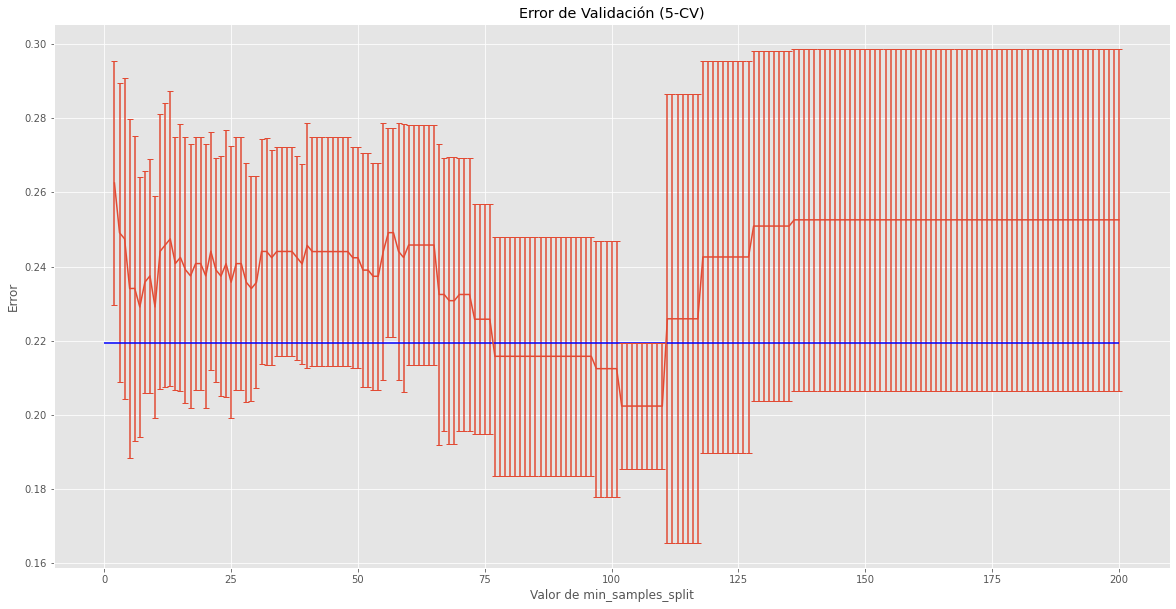

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de min_samples_split")
ax.set_ylabel("Error")
ax.errorbar(cv_results['param_min_samples_split'],
            cv_results['mean_test_score'],
            cv_results['std_test_score'],
            capsize=3)
ax.hlines(y=cv_results_best_error_plus_std, xmin=0, xmax=200, colors='blue')


**Muestra la gráfica del error de test frente al valor del hiper‐parámetro, y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test. ¿Cuál es el menor error de test y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada mediante la regla de una desviación estándar?**

En primer lugar, debemos calcular el error de test frente al valor del hiper-parámetro:

In [27]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_blood_transfusion_train_Y) + [0] * len(df_blood_transfusion_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_blood_transfusion_all_X = np.vstack(
    [df_blood_transfusion_train_X, df_blood_transfusion_test_X])
df_blood_transfusion_all_Y = pd.concat(
    [df_blood_transfusion_train_Y, df_blood_transfusion_test_Y])

decission_tree = DecisionTreeClassifier(criterion='entropy', random_state=SEED_VALUE)
modelCV = GridSearchCV(decission_tree,
                       hyperparameters,
                       cv=ps,
                       return_train_score=True,
                       n_jobs=-1)

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV.fit(df_blood_transfusion_all_X, df_blood_transfusion_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=1),
             n_jobs=-1, param_grid={'min_samples_split': range(2, 201)},
             return_train_score=True)

Guardamos estos resultados y mostramos por pantalla:

In [28]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results['mean_test_score'] = 1 - test_results['mean_test_score']

test_results.loc[:, [
    'param_min_samples_split', 
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
128,130,0.213333,0.0,1
124,126,0.213333,0.0,1
125,127,0.213333,0.0,1
126,128,0.213333,0.0,1
127,129,0.213333,0.0,1
...,...,...,...,...
24,26,0.286667,0.0,190
19,21,0.286667,0.0,190
0,2,0.286667,0.0,190
8,10,0.293333,0.0,198


Ahora procedemos a mostrar las gráficas de error de test frente al valor del hiper-parámetro juento con la gráfica con el error de entrenamiento con validación cruzada para ver si este último hizo una buena estimación del error de test:

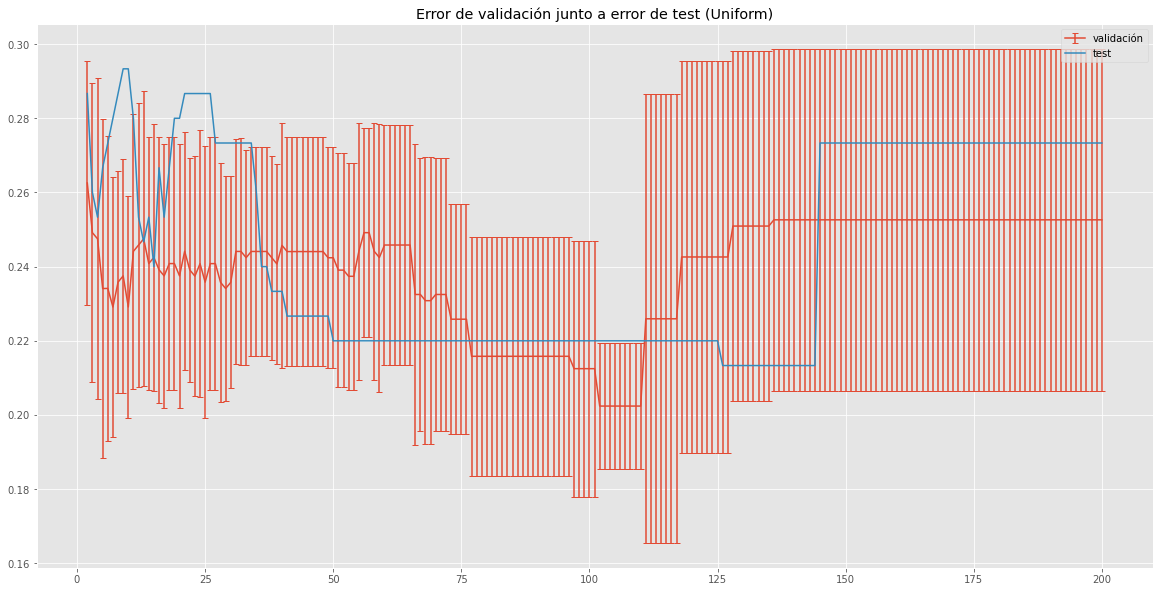

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Error de validación junto a error de test (Uniform)")
ax.errorbar(cv_results['param_min_samples_split'],
               cv_results['mean_test_score'],
               cv_results['std_test_score'],
               label='validación',
               capsize=3)
ax.errorbar(test_results['param_min_samples_split'],
               test_results['mean_test_score'],
               label='test',
               capsize=3)
ax.legend(loc='upper right')


Como se puede ver, la gráfica de entrenamiento no predece correctamente los valores para los errores de test para valores del hiper-parámetro *min_samples_split* por debajo de 50 o por encima de 130, pero sí que lo hacemos relativamente bien entre 50 y 120.

El menor error de test se consigue para los siguientes valores de los hiper-parámetros:

In [30]:
test_results_best = test_results[test_results['rank_test_score'] == 1]
test_results_best.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_min_samples_split',
    ascending=False
).head(1)


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
142,144,0.213333,0.0,1


Siendo el error correspondiente:

In [31]:
test_results_best_error = float(test_results.loc[142, 'mean_test_score'])
test_results_best_error


0.21333333333333337

El error de test para el valor seleccionado por la validación cruzada es:

In [32]:
test_results_cv_error = float(test_results.loc[108, 'mean_test_score'])
test_results_cv_error
               

0.21999999999999997

Y para los valores seleccionados mediante la regla de una desviación estándar:

In [33]:
test_results_cv_one_std_error = float(test_results.loc[108, 'mean_test_score'])
test_results_cv_one_std_error
               

0.21999999999999997

## Ejercicio 3

Ahora trabajaremos con el conjunto de datos de [EnergyEfficiciency](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency).

### Apartado 0

**Analiza las características del conjunto de datos: número y tipo de variables de entrada y salida, número de instancias, número de clases y distribución de las mismas, correlación entre las variables, valores perdidos, etc.**

Repetimos los pasos llevados a cabo para el dataset del ejercicio 2:

In [34]:
df_energy_efficiency = pd.read_csv('data/EnergyEfficiency.data',
                                   delimiter=',',
                                   skiprows=1,
                                   header=None,
                                   names=["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y"])


Este conjunto de datos nos muestra diferentes datos sobre diferentes formas de edifcios y como de eficientes energéticamente son. La variable que queremos predecir es la de la columna `Y` a partir del resto de variables predictoras mediante regresión. El DataFrame cuenta con las siguientes columnas:

In [35]:
df_energy_efficiency


,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.61


El número de instancias presentes en este DataFrame es el siguiente:

In [36]:
df_energy_efficiency.shape


(768, 9)

El tipo de cada una de las columnas presentes en el DataFrame:

In [37]:
print('Tipo de dato de cada columna del Dataframe :')
print(df_energy_efficiency.dtypes)


Tipo de dato de cada columna del Dataframe :
X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y     float64
dtype: object


Comprobamos si hay valores perdidos:

In [38]:
print("Número de valores NaN en cada columna:")
df_energy_efficiency.isna().sum()


Número de valores NaN en cada columna:


X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y     0
dtype: int64

Como no hay valores perdidos, estudiamos el número de clases y la distribución de las mismas:

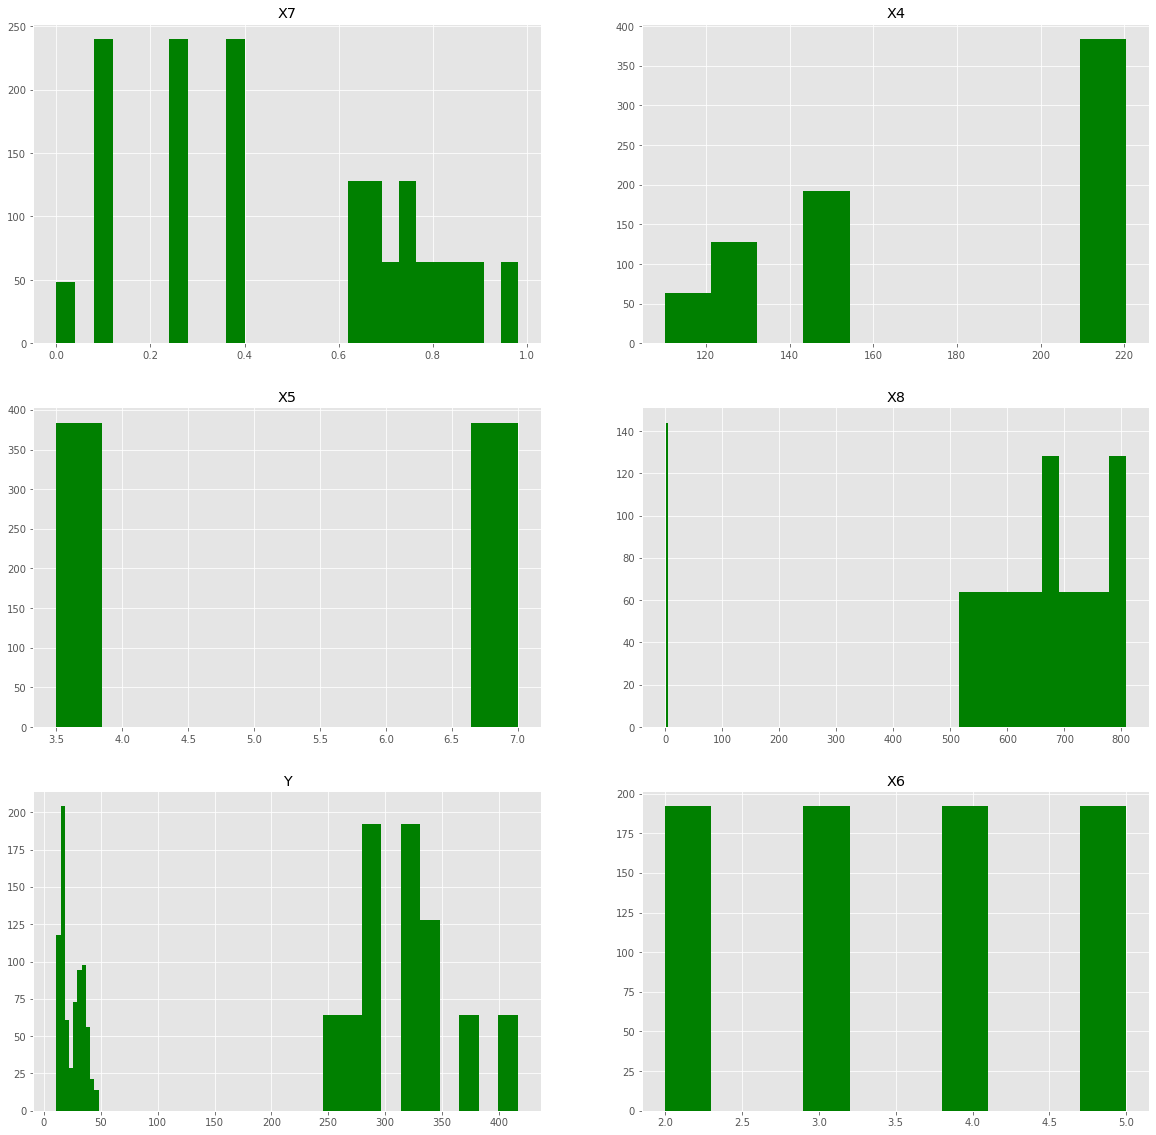

In [39]:
fig, ax = plt.subplots(figsize=(20,20), ncols=2, nrows=3)
i, j = 0, 0

# Visualizamos la distribución de variables por clases
for column in df_energy_efficiency:
    ax[i][j].set_title(column)
    ax[i][j].hist(df_energy_efficiency.loc[:, column], color='green')

    i = i + 1 if i < 2 else 0
    j = j + 1 if j < 1 else 0


Y también comprobamos la correlación entre variables:

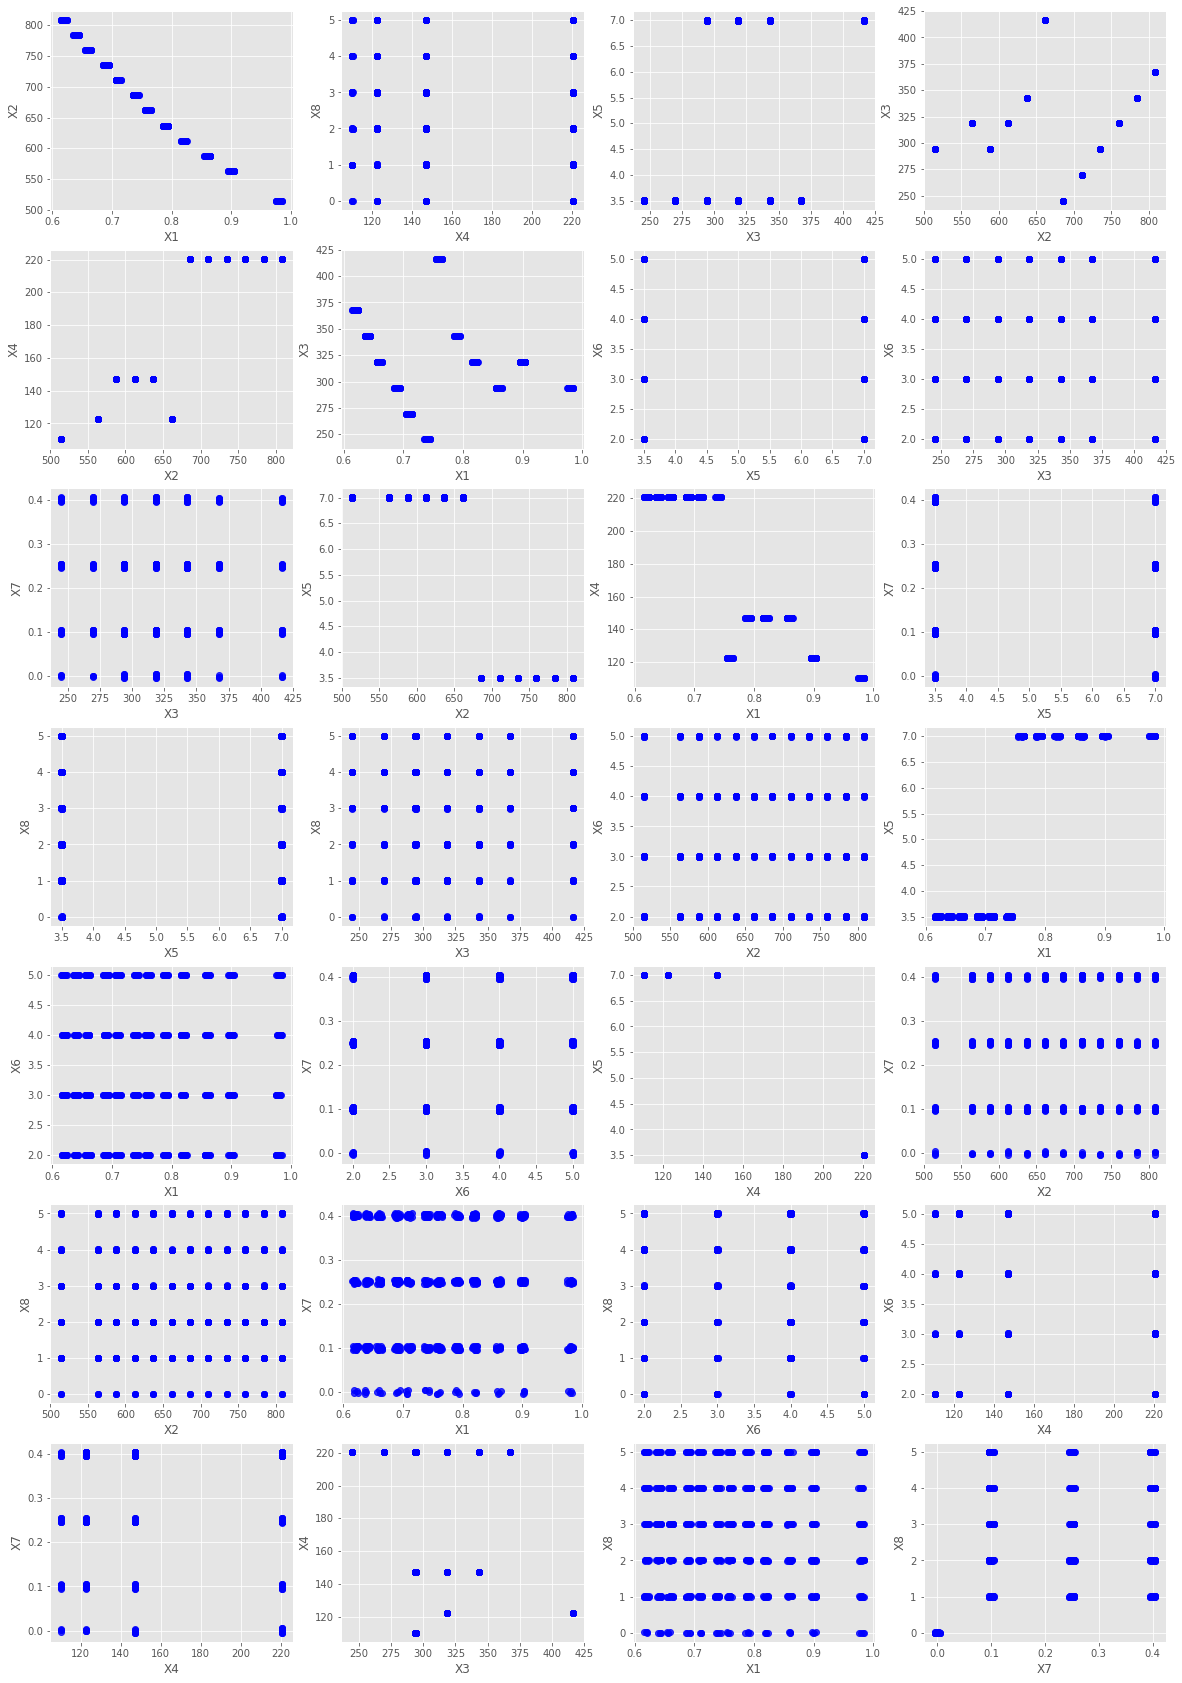

In [40]:
# Omitimos la variable dependiente
column_names = df_energy_efficiency.columns[:-1]

fig, ax = plt.subplots(figsize=(20, 30), nrows=7, ncols=4)
l, k = 0, 0

# Ahora representamos atributos por pares (mostrando también la clase)
for i, columna_i in enumerate(column_names):
    for j, columna_j in enumerate(column_names):
        if i < j:
            sb.regplot(data=df_energy_efficiency, 
                           x=columna_i, 
                           y=columna_j,
                           ax=ax[l][k],
                           color='b',
                           x_jitter=0.005,
                           y_jitter=0.005,
                           fit_reg=False)
            
            l = l + 1 if l < 6 else 0
            k = k + 1 if k < 3 else 0


### Apartado a

**Una de las clases que implementa el algoritmo CART en `scikit‐learn` es `sklearn.tree.DecisionTreeRegressor`. Revisa los parámetros y métodos que tiene.**

Se revisa la documentación de la clase `sklearn.tree.DecisionTreeRegressor.` para entender los parámetros que tiene, qué hace cada uno, y los métodos que tiene, y cuál es la función de cada uno.

### Apartado b

**Divide los datos en entrenamiento (80%) y test (20%).**

Dividimos los datos en entrenamiento (80%) y test (20%) mediante este comando:

In [41]:
df_energy_efficiency_train, df_energy_efficiency_test = train_test_split(
    df_energy_efficiency, 
    test_size=0.2, 
    random_state=SEED_VALUE)


Número de instancias en el conjunto de entrenamiento:

In [42]:
df_energy_efficiency_train.shape


(614, 9)

Número de instancias en el conjunto de test:

In [43]:
df_energy_efficiency_test.shape


(154, 9)

### Apartado c

**Realiza la experimentación con *DecisionTreeRegressor* usando como hiper‐parámetro el min_samples_split.**

En primer lugar, dividimos en variables predictoras y dependientes:

In [44]:
df_energy_efficiency_train_X = df_energy_efficiency_train.loc[:, [
    'X1', 'X2', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_energy_efficiency_train_Y = df_energy_efficiency_train.loc[:, 'Y']

df_energy_efficiency_test_X = df_energy_efficiency_test.loc[:, [
    'X1', 'X2', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].astype(float)
df_energy_efficiency_test_Y = df_energy_efficiency_test.loc[:, 'Y']


Definimos los hiper-parámetros a usar:

In [45]:
hyperparameters = {'min_samples_split': range(2, 201, 1)}


Y ejecutamos el entrenamiento:

In [46]:
decission_tree =  DecisionTreeRegressor(random_state=SEED_VALUE)
modelCV = GridSearchCV(decission_tree,
                       hyperparameters,
                       cv=5,
                       return_train_score=True,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV.fit(df_energy_efficiency_train_X, df_energy_efficiency_train_Y)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'min_samples_split': range(2, 201)},
             return_train_score=True, scoring='neg_mean_squared_error')

Observamos los resultados obtenidos:

In [47]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results['mean_test_score'] = -1 * cv_results['mean_test_score']

cv_results.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score']
].sort_values(
    by="rank_test_score"
).head()


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
13,15,3.400035,0.688360,1
12,14,3.517948,0.658958,2
22,24,3.532346,0.672223,3
21,23,3.533609,0.689998,4
20,22,3.534107,0.599468,5


**Muestra la gráfica del error de entrenamiento con validación cruzada (5‐CV) frente al valor del hiper‐parámetro. ¿Cuál es el menor error de validación cruzada, su desviación estándar y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar?**

Mostramos la gráfica con los resultados del entrenamiento:

<ErrorbarContainer object of 3 artists>

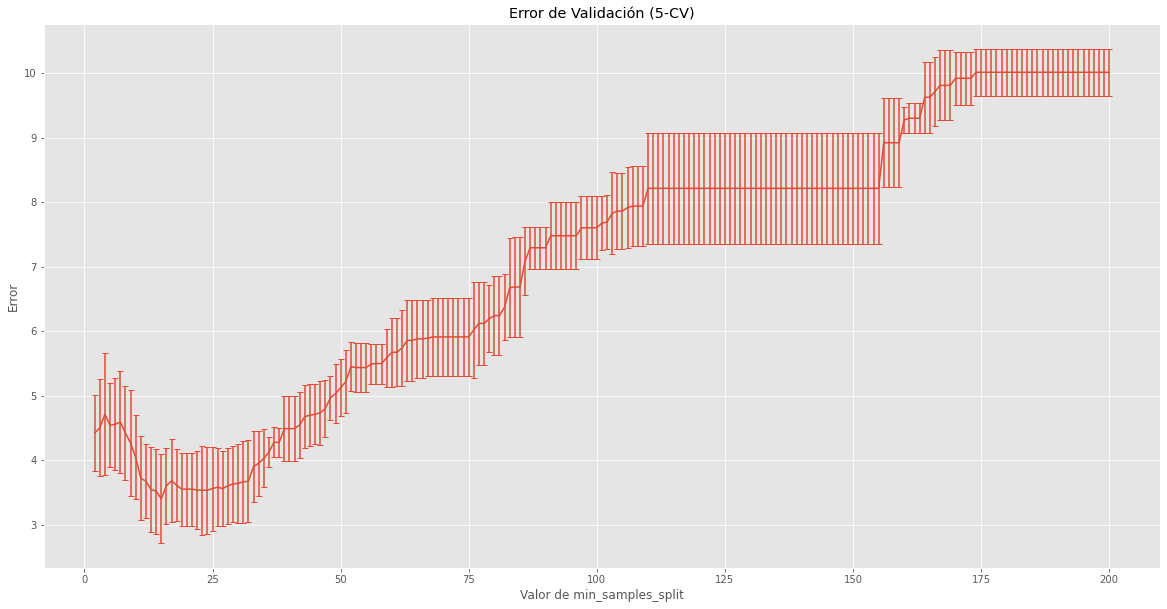

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de min_samples_split")
ax.set_ylabel("Error")
ax.errorbar(cv_results['param_min_samples_split'],
            cv_results['mean_test_score'],
            cv_results['std_test_score'],
            capsize=3)


El menor error de validación cruzada, su desviación estándar y el hiper-parámetro para el que se consigue es el siguiente:

In [49]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_min_samples_split',
    ascending=False
).head(1)


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
13,15,3.400035,0.68836,1


Si se aplicase la regla de la desviación estándar, el valor del hiperparámetro escogido sería el siguiente:

In [62]:
cv_results_best_error = float(cv_results_best.loc[13, 'mean_test_score'])
cv_results_best_std = float(cv_results_best.loc[13, 'std_test_score'])

cv_results_best_error_plus_std = cv_results_best_error + cv_results_best_std

cv_results_one_std = cv_results[
    cv_results['mean_test_score'] <= cv_results_best_error_plus_std
].sort_values(by='param_min_samples_split', ascending=False)

cv_results_one_std.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_min_samples_split', 
    ascending=False
).head(1)


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
33,35,4.024361,0.449845,25


Siendo la gráfica que usamos para decidir los valores de los hiper-parámetros (mediante la regla de una desviación estándar) la siguiente:

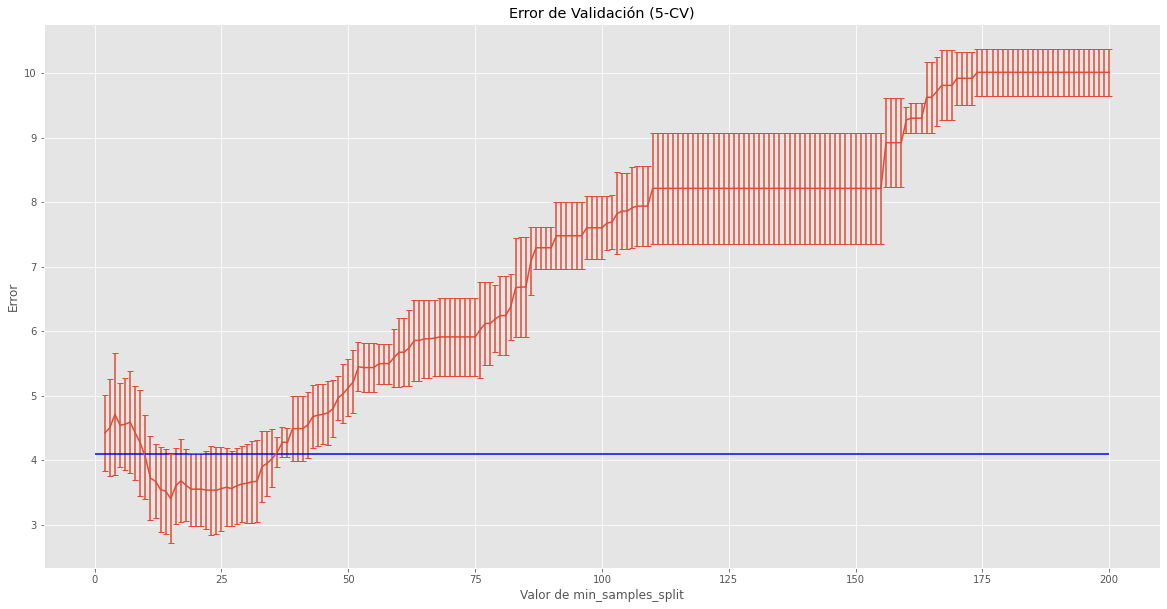

In [63]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de min_samples_split")
ax.set_ylabel("Error")
ax.errorbar(cv_results['param_min_samples_split'],
            cv_results['mean_test_score'],
            cv_results['std_test_score'], 
            capsize=3)
ax.hlines(y=cv_results_best_error_plus_std, xmin=0, xmax=200, colors='blue')


**Muestra la gráfica del error de test frente al valor del hiper‐parámetro, y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test. ¿Cuál es el menor error de test y el valor del hiper‐parámetro para el que se consigue? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada? ¿Cuál es el error de test para el valor del hiper‐parámetro seleccionado por la validación cruzada mediante la regla de una desviación estándar?**

En primer lugar, debemos calcular el error de test frente al valor del hiper-parámetro:

In [64]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1] * len(df_energy_efficiency_train_Y) + [0] * len(df_energy_efficiency_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
df_energy_efficiency_all_X = np.vstack([df_energy_efficiency_train_X, df_energy_efficiency_test_X])
df_energy_efficiency_all_Y = np.hstack([df_energy_efficiency_train_Y, df_energy_efficiency_test_Y])

decission_tree = DecisionTreeRegressor(random_state=SEED_VALUE)
modelCV = GridSearchCV(decission_tree,
                       hyperparameters,
                       cv=ps,
                       return_train_score=True,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)
modelCV.fit(df_energy_efficiency_all_X, df_energy_efficiency_all_Y)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'min_samples_split': range(2, 201)},
             return_train_score=True, scoring='neg_mean_squared_error')

Mostramos el resultado por pantalla:

In [65]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results['mean_test_score'] =  -1 * test_results['mean_test_score']

test_results.loc[:, [
    'param_min_samples_split',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by="rank_test_score"
).head()


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
23,25,3.492052,0.0,1
22,24,3.492052,0.0,1
24,26,3.492052,0.0,1
19,21,3.618426,0.0,4
21,23,3.618776,0.0,5


<ErrorbarContainer object of 3 artists>

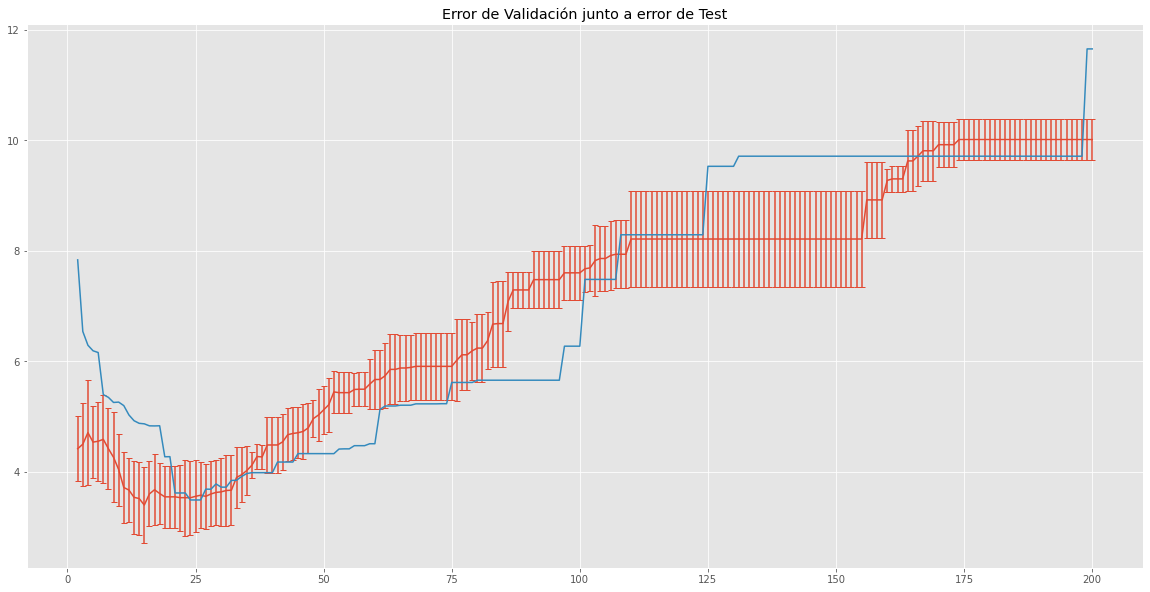

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Error de Validación junto a error de Test")
ax.errorbar(
    cv_results['param_min_samples_split'],
    cv_results['mean_test_score'],
    cv_results['std_test_score'],
    label='validación',
    capsize=3)
ax.errorbar(
    test_results['param_min_samples_split'],
    test_results['mean_test_score'],
    label='test',
    capsize=3)


En este caso el error de entrenamiento predice mucho mejor que en el ejercicio previo el error de test.

El menor error de test se consigue para los siguientes valores de los hiper-parámetros:

In [67]:
test_results_best = test_results[test_results['rank_test_score'] == 1]
test_results_best.loc[:, [
    'param_min_samples_split',
    'mean_test_score', 
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_min_samples_split', 
    ascending=False
).head(1)


,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
24,26,3.492052,0.0,1


Siendo el error correspondiente:

In [68]:
test_results_best_error = float(test_results.loc[24, 'mean_test_score'])
test_results_best_error


3.49205180826997

El error de test para el valor seleccionado por la validación cruzada es:

In [69]:
test_results_cv_error = float(test_results.loc[13, 'mean_test_score'])
test_results_cv_error


4.870069961576666

Y para los valores seleccionados mediante la regla de una desviación estándar:

In [70]:
test_results_cv_std_error = float(test_results.loc[33, 'mean_test_score'])
test_results_cv_std_error


3.9709026558994247

## Ejercicio 4

**¿Crees que sería de interés aplicar un método de selección de variables (Forward stepwise selection, etc.) junto con el algoritmo CART?**

En mi opinión, aplicar algún método de selección de variables como el *forward stepwise selection* podría ser de interés ya que nos permitiría eliminar aquellas variables que no sean muy significativas, dejándonos con un modelo más sencillo (más general) y por lo tanto también más fácil sería interpretar el árbol de selección resultante.

Además, también nos podría permitir ahorrarnos tiempo en el entrenamiento del árbol de decisiones al no tener que comprobar los cortes de aquellas variables que no sean consideradas como significativas tras ejecutar la selección de variables.

Por otra parte, la selección de variables también requiere de un tiempo de cómputo a mayores. Es por esto que cuando estemos ante un número muy alto de variables sí que sea efectivo ejecutar un método para disminuir la dimensión de nuestro problema, para ahorrar algo de tiempo de entrenamiento.